In [1]:
# -*- coding: utf-8 -*-
import re
import pandas as pd
from bs4 import BeautifulSoup 
import pickle
import json
from sklearn.cross_validation import train_test_split

In [2]:
sentimentDictionary="AFINN.json"
labeledbasefile="raw_data/reviews.p"
with open(sentimentDictionary, "r") as rFile:
        sDictionary=rFile.read()
Sdict=json.loads(sDictionary)  

for k in Sdict.keys():
    Sdict[k]=Sdict[k]+5

In [3]:
D= pickle.load(open( labeledbasefile, "rb" ))

In [4]:
reviews=D[D['review_content']!='']
reviews = reviews.reset_index(drop=True)
reviews=reviews[["review_content","Target"]]

In [5]:
D_Accents={"\xea":"e","\xe9":"e","\xe8":"e","\xe0":"a","\xfb":"u","\xf1":"n","\xf2":"o","\xf3":"o","\xf4":"o","\xf5":"o","\xf6":"o"}
for i in D_Accents.keys():
    reviews['review_content']=reviews['review_content'].apply(lambda x: re.sub(i,D_Accents[i],x))

In [6]:
reviews.head()

,review_content,Target
0,Ca serait plutot un film tres bien si ils ont ...,0
1,"Un univers unique, une melodie immortelle, une...",0
2,Je pense que compte-tenu de la rarete de ce fi...,0
3,"un film super top, une excellente surprise, dr...",0
4,"USA, annees 80/90. Un publicitaire Americain a...",1


In [7]:
from nltk.corpus import stopwords
fr_stopwords = set(stopwords.words('french')+['les'])
for i in D_Accents.keys():
    fr_stopwords=[re.sub(i,D_Accents[i],x) for x in fr_stopwords]
from nltk.stem.snowball import FrenchStemmer
st = FrenchStemmer(ignore_stopwords=True)

def count_negation(x):
    d=["non","pas","contrairement","jamais"]
    c=0
    for t in x.split():
        if t in d:
            c=+1
    return c

def neg_words(x):
    l=len(x.split())
    c=0
    for t in x.split():
        if (t in Sdict):
            if Sdict[t]<5:
                c=+1
    if l==0:
        return 0
    return float(c)/l

def pos_words(x):
    l=len(x.split())
    c=0
    for t in x.split():
        if (t in Sdict):
            if Sdict[t]>5:
                c=+1
    if l==0:
        return 0
    return float(c)/l

def sentiment_score_lexicon(x):
    s=0
    n=0
    for t in x.split():
        if t in Sdict:
            s=+Sdict[t]
            n=+1
    if n==0:
        return 0
    return float(s)/n

In [8]:
reviews["review_relevant"]=reviews["review_content"].apply(lambda x: " ".join([t for t in x.split() if t not in fr_stopwords]))
reviews["review_stemmed"]=reviews["review_relevant"].apply(lambda x: st.stem(x))
reviews["review_length"]=reviews["review_relevant"].apply(lambda x: len(x))
reviews["review_neg"]=reviews["review_content"].apply(lambda x: count_negation(x))
reviews["review_neg_words"]=reviews["review_content"].apply(lambda x: neg_words(x))
reviews["review_pos_words"]=reviews["review_content"].apply(lambda x: pos_words(x))
reviews["review_Lexicon_score"]=reviews["review_content"].apply(lambda x: sentiment_score_lexicon(x))

In [9]:
reviews.head()

,review_content,Target,review_relevant,review_stemmed,review_length,review_neg,review_neg_words,review_pos_words,review_Lexicon_score
0,Ca serait plutot un film tres bien si ils ont ...,0,Ca plutot film tres bien si ils engager Richar...,ca plutot film tres bien si ils engager richar...,155,1,0.000000,0.030303,10.0
1,"Un univers unique, une melodie immortelle, une...",0,"Un univers unique, melodie immortelle, oeuvre ...","un univers unique, melodie immortelle, oeuvre ...",453,0,0.010753,0.000000,3.0
2,Je pense que compte-tenu de la rarete de ce fi...,0,"Je pense compte-tenu rarete film, prix ici der...","je pense compte-tenu rarete film, prix ici der...",243,0,0.000000,0.020833,8.0
3,"un film super top, une excellente surprise, dr...",0,"film super top, excellente surprise, drole ins...","film super top, excellente surprise, drole ins...",172,0,0.000000,0.029412,8.0
4,"USA, annees 80/90. Un publicitaire Americain a...",1,"USA, annees 80/90. Un publicitaire Americain c...","usa, annees 80/90. un publicitaire americain c...",187,0,0.000000,0.000000,0.0


In [10]:
from pattern.fr import parse, split

In [11]:
reviews['comment_tokens'] = reviews['review_content'].apply(lambda x: parse(x, chunks = False, lemmata = True).split()[0])

In [12]:
reviews['comment_lemmas'] = reviews['comment_tokens'].apply(lambda x: " ".join([t[2] for t in x ]))

In [13]:
reviews.head()

,review_content,Target,review_relevant,review_stemmed,review_length,review_neg,review_neg_words,review_pos_words,review_Lexicon_score,comment_tokens,comment_lemmas
0,Ca serait plutot un film tres bien si ils ont ...,0,Ca plutot film tres bien si ils engager Richar...,ca plutot film tres bien si ils engager richar...,155,1,0.000000,0.030303,10.0,"[[Ca, VB, cer], [serait, VB, être], [plutot, N...",cer être plutot un film tre bien si il avoir p...
1,"Un univers unique, une melodie immortelle, une...",0,"Un univers unique, melodie immortelle, oeuvre ...","un univers unique, melodie immortelle, oeuvre ...",453,0,0.010753,0.000000,3.0,"[[Un, DT, un], [univers, NN, univers], [unique...","un univers unique , une melodie immortel , une..."
2,Je pense que compte-tenu de la rarete de ce fi...,0,"Je pense compte-tenu rarete film, prix ici der...","je pense compte-tenu rarete film, prix ici der...",243,0,0.000000,0.020833,8.0,"[[Je, PRP, je], [pense, VB, penser], [que, IN,...",je penser que compte-tenu de la rarete de ce f...
3,"un film super top, une excellente surprise, dr...",0,"film super top, excellente surprise, drole ins...","film super top, excellente surprise, drole ins...",172,0,0.000000,0.029412,8.0,"[[un, DT, un], [film, NN, film], [super, NN, s...","un film super top , une excellent surprise , d..."
4,"USA, annees 80/90. Un publicitaire Americain a...",1,"USA, annees 80/90. Un publicitaire Americain c...","usa, annees 80/90. un publicitaire americain c...",187,0,0.000000,0.000000,0.0,"[[USA, NNPS, usa], [,, ,, ,], [annees, NNS, an...","usa , annee 80 ."


# Model training

## 1. Modèles simples: des features basiques

### Cross validation split 

In [14]:
Simple_reviews= reviews[["Target","review_length","review_neg","review_neg_words","review_pos_words","review_Lexicon_score"]]
X_train, X_test, y_train, y_test = train_test_split(Simple_reviews[["review_length","review_neg","review_neg_words","review_pos_words","review_Lexicon_score"]], Simple_reviews["Target"], test_size=0.4, random_state=0)
X_train.head()

,review_length,review_neg,review_neg_words,review_pos_words,review_Lexicon_score
13373,275,0,0.014286,0.014286,4.0
4056,65,0,0.000000,0.000000,0.0
29862,276,0,0.014286,0.014286,3.0
7221,134,1,0.000000,0.045455,8.0
28123,52,0,0.000000,0.111111,8.0


### Entrainement et test des modèles

#### a. Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 1200) 

forest = clf.fit( X_train,  y_train)
#pred_train = forest3.predict(features)

In [21]:
forest.score(X_test, y_test) 

0.58078125000000003

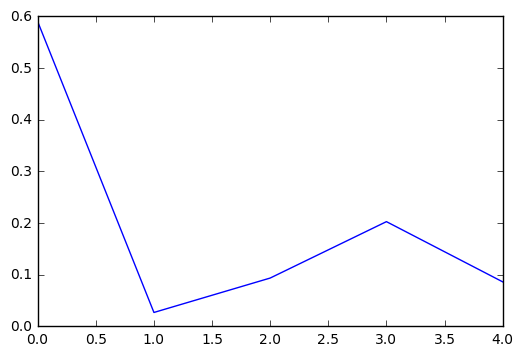

In [22]:
importances = forest.feature_importances_

import matplotlib.pyplot as plt
plt.plot(importances)
plt.show()


#### b. Gradient Boosting Model

In [23]:
from sklearn.ensemble import GradientBoostingClassifier
GB = GradientBoostingClassifier(n_estimators = 1200) 

GBM = GB.fit( X_train,  y_train)
#pred_train = GBM.predict(features)

In [24]:
GBM.score(X_test, y_test) 

0.60399999999999998

#### c. Support Vector Machine

L'entrainement de SVM est très consommateur de puissance de calcul...

In [ ]:
from sklearn import svm

In [ ]:
SVM = svm.SVC(C=1.0, kernel='linear')
%time SVM1=SVM.fit( X_train,  y_train) 

In [ ]:
%time SVM1.score(X_test, y_test) 

In [ ]:
from sklearn import svm
SVM_2 = svm.SVC(C=1.0, kernel='poly')
SVM2=SVM_2.fit( X_train,  y_train) 

In [ ]:
SVM2.score(X_test, y_test) 

## 2. Modèle composé: des features avancés

### Vectorisation des données:  Term Centrality-Invese Document Frequency 
Une méthode de vectorisation du corpus qui "respecte" l'ordre des mots dans les phrases en lui accordant un poids correspondant à la centralité du noeud du mot dans le graph des mots des documents, puis le multiplie par la correction IDF qu permet d'éliminer les stopwords (les mots non significatifs qui sont dans tout les textes presque).

##### createGraphFeatures Function definition 

In [15]:
# Code copié, cf : https://github.com/y3nk0/Graph-Based-TC 
import networkx as nx
import string
from sys import maxint
import numpy as np
import time
import re
import os.path
import math
from scipy.stats import pearsonr,kendalltau
import matplotlib.pyplot as plt

#===============================================================================
# core_Size_Distribution(core_sequence)
#===============================================================================
def core_Size_Distribution(core_sequence):
    """
    core_Size_Distribution(core_sequence)
    The function takes as input the core sequence of a graph and returns the distribution
    of the cores' sizes (k-core size vs. k)
    """

    max_core_number = max(core_sequence.values()) #maximum core number

    # core_sizes: size of each core indexed by position
    (core_sizes, x, y) = plt.hist(core_sequence.values(), bins=max_core_number)

    print "Core sizes:", core_sizes, "\n"
    #print max_core_number

    # plot in log-log axis
    # x: core size, k    y: number of nodes in k-core
    plt.loglog(range(1, len(core_sizes)+1), core_sizes, 'o-', linewidth=2)
    plt.xlabel('Core Number, k')
    plt.ylabel('Size of Core')

    plt.show()

def createGraphFeatures(num_documents,clean_train_documents,unique_words,bigrams,sliding_window,b,idf_par,centrality_par,centrality_col_par,train_par,idf_learned,icw_learned,kcore_par,dGcol_nodes,max_core_col,kcore_par_int,max_core_feat,feature_reduction,avgLen):
    features = np.zeros((num_documents,len(unique_words)))
    unique_words_len = len(unique_words)
    term_num_docs = {}

    print "sliding_window:"+str(sliding_window)
    if train_par:
        print "Training set..."
        idfs = {}
        dGcol_nodes = {}
        icws = {}
        max_core_feat = []

        print "Creating the graph of words for collection..."

        if centrality_col_par=="pagerank_centrality" or centrality_col_par=="in_degree_centrality" or centrality_col_par=="out_degree_centrality" or centrality_col_par=="closeness_centrality_directed" or centrality_col_par=="betweenness_centrality_directed":
            dGcol = nx.DiGraph()
        else:
            dGcol = nx.Graph()
        
        totalLen = 0
        for i in range( 0,num_documents ):
            #dG = nx.Graph()
            found_unique_words = []
            wordList1 = clean_train_documents[i].split(None)
            wordList2 = [string.rstrip(x.lower(), ',.!?;') for x in wordList1]

            docLen = len(wordList2)
            totalLen += docLen

            # print clean_train_documents[i]
            if len(wordList2)>1:
                for k, word in enumerate(wordList2):

                    if word not in found_unique_words:
                        found_unique_words.append(word)
                        if word not in term_num_docs:
                            term_num_docs[word] = 1
                        else:
                            term_num_docs[word] += 1

                    for j in xrange(1,sliding_window):
                        try:
                            next_word = wordList2[k + j]
                            # print word+"\t"+next_word
                            # time.sleep(2)
                            if not dGcol.has_node(word):
                                dGcol.add_node(word)
                                dGcol.node[word]['count'] = 1
                                
                            else:
                                dGcol.node[word]['count'] += 1
                                
                            if not dGcol.has_node(next_word):
                                dGcol.add_node(next_word)
                                dGcol.node[next_word]['count'] = 0

                            if not dGcol.has_edge(word, next_word):
                                dGcol.add_edge(word, next_word, weight = 1)
                            else:
                                dGcol.edge[word][next_word]['weight'] += 1
                        except IndexError:
                            if not dGcol.has_node(word):
                                dGcol.add_node(word)
                                dGcol.node[word]['count'] = 1
                            else:
                                dGcol.node[word]['count'] += 1
                        except:
                            raise

        print "Number of self-loops for collection graph:"+str(dGcol.number_of_selfloops())
        dGcol.remove_edges_from(dGcol.selfloop_edges())
        collection_count_nodes = dGcol.number_of_nodes()
        collection_count_edges = dGcol.number_of_edges()
        print "Number of nodes in collection graph:"+str(collection_count_nodes)
        print "Number of edges in collection graph:"+str(collection_count_edges)
        avgLen = float(totalLen)/num_documents
        print "Average document length:"+str(avgLen)
        
   
        if idf_par=="icw" or idf_par=="icw+idf" or idf_par=="tf-icw":
            icw_col = {}

            if(kcore_par=="A1" or kcore_par=="A2"):
                collection_core = nx.core_number(dGcol)
                max_core = max(collection_core.values())
                print "Max core of collection:"+str(max_core)
                # core_Size_Distribution(collection_core)
                for k,g in enumerate(dGcol.nodes()):
                    if kcore_par=="A1":
                        # A1 method: remove features and then rank
                        for x in range(0,kcore_par_int):
                            if collection_core[g]==max_core-x:
                                dGcol.remove_node(g)
                    else:
                        # A2 method: rank first and then remove features
                        for x in range(0,kcore_par_int):
                            if collection_core[g]==max_core-x:
                                max_core_col.append(g)


            if centrality_col_par == "degree_centrality":
                centrality_col = nx.degree_centrality(dGcol)
            elif centrality_col_par=="in_degree_centrality":
                centrality_col = nx.in_degree_centrality(dGcol)
            elif centrality_col_par=="out_degree_centrality":
                centrality_col = nx.out_degree_centrality(dGcol)
            elif centrality_col_par == "pagerank_centrality":
                # centrality_col = pg.pagerank(dGcol,max_iter=1000)
                centrality_col = nx.pagerank(dGcol)
            elif centrality_col_par == "eigenvector_centrality":
                centrality_col = nx.eigenvector_centrality(dGcol,max_iter=1000)
            elif centrality_col_par == "betweenness_centrality" or centrality_col_par=="betweenness_centrality_directed":
                centrality_col = nx.betweenness_centrality(dGcol)
            elif centrality_col_par == "triangles":
                centrality_col = nx.triangles(dGcol)
            elif centrality_col_par == "clustering_coefficient":
                centrality_col = nx.clustering(dGcol)
            elif centrality_col_par == "core_number":
                centrality_col = nx.core_number(dGcol)
            elif centrality_col_par == "closeness_centrality" or centrality_col_par=="closeness_centrality_directed":
                centrality_col = nx.closeness_centrality(dGcol)
            elif centrality_col_par == "closeness_centrality_weighted":
                centrality_col = nx.closeness_centrality(dGcol)
            elif centrality_col_par == "communicability_centrality":
                centrality_col = nx.communicability_centrality(dGcol)

            centr_sum = sum(centrality_col.values())
            for k,g in enumerate(dGcol.nodes()):
                if centrality_col[g]!=0:
                    if idf_par=="icw" or idf_par=="tf-icw" or idf_par=="icw+idf":
                        icw_col[g] = math.log10(float(centr_sum)/centrality_col[g])
                else:
                    icw_col[g] = 0

        # elif idf_par=="idf":
        idf_col = {}
        for x in term_num_docs:
            if idf_par=="idf":
                idf_col[x] = math.log10((float(num_documents)+1.0) / term_num_docs[x])
            elif idf_par=="icw+idf":
                idf_col[x] = math.log10((float(num_documents)+1.0) / term_num_docs[x])

        dGcol_nodes = dGcol.nodes()

    # for the testing set
    else:

        if idf_par=="idf":
            idf_col = idf_learned
        elif idf_par=="icw" or idf_par=="tf-icw":
            icw_col = icw_learned
        elif idf_par=="icw+idf":
            idf_col = idf_learned
            icw_col = icw_learned

        collection_count_nodes = 0
        collection_count_edges = 0

    # nx.write_edgelist(dGcol,"test.edgelist",data=True,delimiter="\t")

    print "Creating the graph of words for each document..."
    totalNodes = 0
    totalEdges = 0

    corrs_per_category = [[] for i in range(4)]

    for i in range( 0,num_documents ):

        if centrality_par=="pagerank_centrality" or centrality_par=="in_degree_centrality" or centrality_par=="out_degree_centrality" or centrality_par=="closeness_centrality_directed" or centrality_par=="betweenness_centrality_directed":
            dG = nx.DiGraph()
        else:
            dG = nx.Graph()

        wordList1 = clean_train_documents[i].split(None)
        wordList2 = [string.rstrip(x.lower(), ',.!?;') for x in wordList1]
        docLen = len(wordList2)

        if len(wordList2)>1:
            for k, word in enumerate(wordList2):
                for j in xrange(1,sliding_window):
                    try:
                        next_word = wordList2[k + j]
                        
                        if not dG.has_node(word):
                            dG.add_node(word)
                            dG.node[word]['count'] = 1
                        else:
                            dG.node[word]['count'] += 1

                        if not dG.has_node(next_word):
                            dG.add_node(next_word)
                            dG.node[next_word]['count'] = 1

                        if not dG.has_edge(word, next_word):
                            dG.add_edge(word, next_word, weight = 1)
                        else:
                            dG.edge[word][next_word]['weight'] += 1
                    except IndexError:
                        if not dG.has_node(word):
                            dG.add_node(word)
                            dG.node[word]['count'] = 1
                        else:
                            dG.node[word]['count'] += 1
                    except:
                        raise

            dG.remove_edges_from(dG.selfloop_edges())
            for node1, node2 in dG.edges_iter():
                dG.edge[node1][node2]['inv_weight'] = 1.0 / dG.edge[node1][node2]['weight']

            if train_par:
                if(kcore_par=="B1" or kcore_par=="B2"):
                    max_core_doc = []
                    document_core = nx.core_number(dG)
                    max_core = max(document_core.values())
                    # print "Max core of document:"+str(max_core)
                    # core_Size_Distribution(document_core)
                    for k,g in enumerate(dG.nodes()):
                        if kcore_par=="B1":
                            # B1 method: remove features and then rank
                            for x in range(0,kcore_par_int):
                                if document_core[g]==max_core-x:
                                    dG.remove_node(g)
                        else:
                            # B2 method: rank first and then remove features
                            for x in range(0,kcore_par_int):
                                if document_core[g]==max_core-x:
                                    max_core_doc.append(g)
                                    if g not in max_core_feat:
                                        max_core_feat.append(g)
            
            # centrality = nx.degree_centrality(dG)
            #centrality = nx.core_number(dG)
            if centrality_par == "degree_centrality":
                centrality = nx.degree_centrality(dG)
            elif centrality_par == "in_degree_centrality":
                centrality = nx.in_degree_centrality(dG)
            elif centrality_par == "out_degree_centrality":
                centrality = nx.out_degree_centrality(dG)
            elif centrality_par == "pagerank_centrality":
                # centrality = pg.pagerank(dG,max_iter=1000)
                centrality = nx.pagerank(dG)
            elif centrality_par =="betweenness_centrality" or centrality_par=="betweenness_centrality_directed":
                centrality = nx.betweenness_centrality(dG,weight="weight")
            elif centrality_par =="triangles":
                centrality = nx.triangles(dG)
            elif centrality_par =="eigenvector_centrality":
                centrality = nx.eigenvector_centrality_numpy(dG)
            elif centrality_par =="core_number":
                centrality = nx.core_number(dG)
            elif centrality_par =="clustering_coefficient":
                centrality = nx.clustering(dG)
            elif centrality_par == "closeness_centrality" or centrality_par=="closeness_centrality_directed":
                centrality = nx.closeness_centrality(dG)
            elif centrality_par == "closeness_centrality_weighted":
                centrality = nx.closeness_centrality(dG,distance='weight')
            elif centrality_par == "communicability_centrality":
                centrality = nx.communicability_centrality(dG)
            elif centrality_par == "closeness_centrality_not_normalized":
                centrality = nx.closeness_centrality(dG,normalized=False)
            elif centrality_par == "degree_centrality_weighted":
                centrality = weighted_degree_centrality(dG)
            #print "Number of self-loops:"+str(dG.number_of_selfloops())
            #centrality = nx.out_degree_centrality(dG)
            #centrality = pg.pagerank(dG,max_iter=1000)
            #centrality = nx.katz_centrality(dG,max_iter=10000)

            totalNodes += dG.number_of_nodes()
            totalEdges += dG.number_of_edges()

            tfs = []
            centralities = []
            centr_sum_doc = sum(centrality.values())

            for k, g in enumerate(dG.nodes()):
                if g in dGcol_nodes:
                    if kcore_par=="B2":
                        if g in max_core_feat:
                            # Degree centrality (local feature)
                            if g in unique_words:
                                #features[i,unique_words.index(g)] = dG.degree(nbunch=g,weight='weight') * idf_col[g]
                                if idf_par=="no":
                                    features[i,unique_words.index(g)] = centrality[g]/(1-b+(b*(float(docLen)/avgLen)))
                                elif idf_par=="idf":
                                    features[i,unique_words.index(g)] = (centrality[g]/(1-b+(b*(float(docLen)/avgLen)))) * idf_col[g]
                                    # features[i,unique_words.index(g)] = centrality[g] * idf_col[g]
                                elif idf_par=="icw":
                                    features[i,unique_words.index(g)] = (centrality[g]/(1-b+(b*(float(docLen)/avgLen)))) * icw_col[g]
                                    # features[i,unique_words.index(g)] = centrality[g] * icw_col[g]
                                elif idf_par=="icw+idf":
                                    features[i,unique_words.index(g)] = (centrality[g]/(1-b+(b*(float(docLen)/avgLen)))) * icw_col[g] * idf_col[g]
                                    # features[i,unique_words.index(g)] = centrality[g] * math.log10(icw_col[g] * idf_col[g])

                            elif g in bigrams:
                                #features[i,unique_words.index(g)] = dG.degree(nbunch=g,weight='weight') * idf_col[g]
                                if idf_par=="no":
                                    features[i,unique_words_len+bigrams.index(g)] = centrality[g]/(1-b+(b*(float(docLen)/avgLen)))
                                elif idf_par=="idf":
                                    features[i,unique_words_len+bigrams.index(g)] = (centrality[g]/(1-b+(b*(float(docLen)/avgLen)))) * idf_col[g]
                                    # features[i,unique_words.index(g)] = centrality[g] * idf_col[g]
                                elif idf_par=="icw":
                                    features[i,unique_words_len+bigrams.index(g)] = (centrality[g]/(1-b+(b*(float(docLen)/avgLen)))) * icw_col[g]
                                    # features[i,unique_words.index(g)] = centrality[g] * icw_col[g]
                                elif idf_par=="icw+idf":
                                    features[i,unique_words_len+bigrams.index(g)] = (centrality[g]/(1-b+(b*(float(docLen)/avgLen)))) * icw_col[g] * idf_col[g]
                                    # features[i,unique_words.index(g)] = centrality[g] * math.log10(icw_col[g] * idf_col[g])
                    else:
                        if g in unique_words:
                            #features[i,unique_words.index(g)] = dG.degree(nbunch=g,weight='weight') * idf_col[g]
                            if idf_par=="no":
                                features[i,unique_words.index(g)] = centrality[g]/(1-b+(b*(float(docLen)/avgLen)))
                                tfs.append(wordList2.count(g))
                                centralities.append(centrality[g])
                            elif idf_par=="tf-icw":
                                tf_g = 1+math.log(1+math.log(wordList2.count(g)))
                                features[i,unique_words.index(g)] = (tf_g/(1-b+(b*(float(docLen)/avgLen)))) * icw_col[g]
                            elif idf_par=="idf":
                                features[i,unique_words.index(g)] = (centrality[g]/(1-b+(b*(float(docLen)/avgLen)))) * idf_col[g]
                                # features[i,unique_words.index(g)] = centrality[g] * idf_col[g]
                            elif idf_par=="icw":
                                features[i,unique_words.index(g)] = (centrality[g]/(1-b+(b*(float(docLen)/avgLen)))) * icw_col[g]
                                # features[i,unique_words.index(g)] = centrality[g] * icw_col[g]
                            elif idf_par=="icw+idf":
                                features[i,unique_words.index(g)] = (centrality[g]/(1-b+(b*(float(docLen)/avgLen)))) * icw_col[g] * idf_col[g]
                                # features[i,unique_words.index(g)] = centrality[g] * math.log10(icw_col[g] * idf_col[g])

                        elif g in bigrams:
                            #features[i,unique_words.index(g)] = dG.degree(nbunch=g,weight='weight') * idf_col[g]
                            if idf_par=="no":
                                features[i,unique_words_len+bigrams.index(g)] = centrality[g]/(1-b+(b*(float(docLen)/avgLen)))
                            elif idf_par=="idf":
                                features[i,unique_words_len+bigrams.index(g)] = (centrality[g]/(1-b+(b*(float(docLen)/avgLen)))) * idf_col[g]
                                # features[i,unique_words.index(g)] = centrality[g] * idf_col[g]
                            elif idf_par=="icw":
                                features[i,unique_words_len+bigrams.index(g)] = (centrality[g]/(1-b+(b*(float(docLen)/avgLen)))) * icw_col[g]
                                # features[i,unique_words.index(g)] = centrality[g] * icw_col[g]
                            elif idf_par=="icw+idf":
                                features[i,unique_words_len+bigrams.index(g)] = (centrality[g]/(1-b+(b*(float(docLen)/avgLen)))) * icw_col[g] * idf_col[g]
                                # features[i,unique_words.index(g)] = centrality[g] * math.log10(icw_col[g] * idf_col[g])
    #     if train_par:
    #         # pears = pearsonr(tfs,centralities)

    #         ind_tfs = sorted(range(len(tfs)), key=lambda k: tfs[k])[-20:]
    #         ind_centr = sorted(range(len(centralities)), key=lambda k: centralities[k])[-20:]
    #         tau, p_value = kendalltau([unique_words[k] for k in ind_tfs],[unique_words[k] for k in ind_centr])
            
    #         corrs_per_category[int(y[i])-1].append(tau)
    
    # if train_par:

    #     text_file = open("kendal_tfs_tws_output_tw_idf_"+idf_par+"_centr_"+centrality_par+"_sliding_"+str(sliding_window)+"_kcore_"+kcore_par+".txt", "w")
        
    #     text_file.write(str(corrs_per_category))
    #     text_file.close()

    #     fig = plt.figure()
    #     ax = fig.add_subplot(111)

    #     ax.boxplot(corrs_per_category[:])

    #     plt.show()


    if idf_par=="no":
        idfs = {}
        icws = {}
    if idf_par=="idf":
        idfs = idf_col
        icws = {}
    elif idf_par=="icw" or idf_par=="tf-icw":
        idfs = {}
        icws = icw_col
    elif idf_par=="icw+idf":
        idfs = idf_col
        icws = icw_col

    if train_par:
        if kcore_par=="B2":
            feature_reduction = float(len(max_core_feat))/len(dGcol_nodes)
            print "Percentage of features kept:"+str(feature_reduction)
        print "Average number of nodes:"+str(float(totalNodes)/num_documents)
        print "Average number of edges:"+str(float(totalEdges)/num_documents)
    
    return features, idfs,icws,collection_count_nodes, collection_count_edges, dGcol_nodes,max_core_col,feature_reduction, max_core_feat,avgLen

In [14]:
X_train, X_test, y_train, y_test = train_test_split(reviews["review_stemmed"], reviews["Target"], test_size=0.4, random_state=0)

In [16]:
X_train.head()

13373    corpse killer 3do jeu tir deroulant comme film...
4056     c pink floyd ! ca suffit savoir qu'il l'album ...
29862    belle alure tre belle fourche couleur belle co...
7221     tres bon produit,surtout debut l'allaitement.l...
28123    trees bon telephone enormement d'option tres d...
Name: review_stemmed, dtype: object

In [17]:
N=3000
clean_train_documents = list(X_train)[:N]
num_documents=len(clean_train_documents)
unique_words = list(set((" ".join(clean_train_documents).split())))
bigrams = []
sliding_window=2
b = 0.03
idf_par = "idf"
centrality_par = "betweenness_centrality_directed"
centrality_col_par=centrality_par
idfs = {}
icws = {}
kcore_par = "A0"
dGcol_nodes = {}
max_core_col = []
kcore_par_int = 1
max_core_feat = []
feature_reduction = 0.0
avgLen = 0.0

In [18]:
features, idfs_learned,icws_learned,collection_count_nodes, collection_count_edges, dGcol_nodes,max_core_col,feature_reduction, max_core_feat,avgLen = createGraphFeatures(num_documents,clean_train_documents,unique_words,bigrams,sliding_window,b,idf_par,centrality_par,centrality_col_par,True,idfs,icws,kcore_par,dGcol_nodes,max_core_col,kcore_par_int,max_core_feat,feature_reduction,avgLen)

sliding_window:2
Training set...
Creating the graph of words for collection...
Number of self-loops for collection graph:37
Number of nodes in collection graph:14504
Number of edges in collection graph:46037
Average document length:19.6166666667
Creating the graph of words for each document...
Average number of nodes:18.0953333333
Average number of edges:18.4336666667


In [19]:
features.shape

(3000, 17616)

### Entrainement et test des modèles

In [20]:
N_test=500
clean_test_documents = list(X_test[:N_test])
num_test_documents=len(clean_test_documents)
test_features,idfs,icws,collection_count_nodes, collection_count_edges, dGcol_nodes,max_core_col,feature_reduction, max_core_feat,avgLen = createGraphFeatures(num_test_documents,clean_test_documents,unique_words,bigrams,sliding_window,b,idf_par,centrality_par,centrality_col_par,False,idfs_learned,icws_learned,kcore_par,dGcol_nodes,max_core_col,kcore_par_int,max_core_feat,feature_reduction,avgLen)

sliding_window:2
Creating the graph of words for each document...


#### a. Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier
clf_2 = RandomForestClassifier(n_estimators = 500) 

forest_2 = clf_2.fit( features, y_train [:N])
#pred_train = forest.predict(features)

In [23]:
forest_2.score(test_features, y_test[:N_test]) 

0.59799999999999998

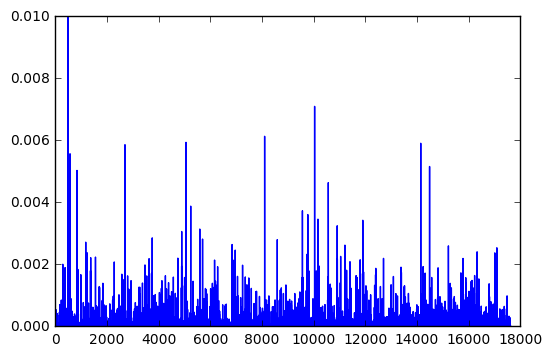

In [24]:
importances_2 = forest_2.feature_importances_

import matplotlib.pyplot as plt
plt.plot(importances_2)
plt.show()


Les mots les plus important dans les arbres de décision

In [25]:
unique_words[list(importances_2).index(max(importances_2))]

u'tres'

In [31]:
l=list(importances_2)

l[list(importances_2).index(max(importances_2))]=0

unique_words[l.index(max(l))]

u'bon'

In [32]:
l2=l

l2[l.index(max(l))]=0

unique_words[l2.index(max(l2))]

u'qualite'

#### b.  Gradient Boosting Classifier

In [34]:
from sklearn.ensemble import GradientBoostingClassifier
GB2 = GradientBoostingClassifier(n_estimators = 500) 

GBM2 = GB2.fit( features, y_train [:N])

In [35]:
GBM2.score(test_features, y_test[:N_test]) 

0.55200000000000005

### Modèles hybrides

In [16]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(reviews[["review_stemmed","review_neg","review_Lexicon_score","review_length"]], reviews["Target"], test_size=0.4, random_state=0)

In [17]:
N=3000
clean_train_documents = list(X_train1["review_stemmed"])[:N]
num_documents=len(clean_train_documents)
unique_words = list(set((" ".join(clean_train_documents).split())))
bigrams = []
sliding_window=2
b = 0.03
idf_par = "idf"
centrality_par = "betweenness_centrality_directed"
centrality_col_par=centrality_par
idfs = {}
icws = {}
kcore_par = "A0"
dGcol_nodes = {}
max_core_col = []
kcore_par_int = 1
max_core_feat = []
feature_reduction = 0.0
avgLen = 0.0

In [18]:
features, idfs_learned,icws_learned,collection_count_nodes, collection_count_edges, dGcol_nodes,max_core_col,feature_reduction, max_core_feat,avgLen = createGraphFeatures(num_documents,clean_train_documents,unique_words,bigrams,sliding_window,b,idf_par,centrality_par,centrality_col_par,True,idfs,icws,kcore_par,dGcol_nodes,max_core_col,kcore_par_int,max_core_feat,feature_reduction,avgLen)

sliding_window:2
Training set...
Creating the graph of words for collection...
Number of self-loops for collection graph:37
Number of nodes in collection graph:14504
Number of edges in collection graph:46037
Average document length:19.6166666667
Creating the graph of words for each document...
Average number of nodes:18.0953333333
Average number of edges:18.4336666667


In [24]:
df=X_train1[["review_neg","review_Lexicon_score","review_length"]][:N]

df1=pd.DataFrame(features, columns=unique_words, index=df.index)

X_train_DF=pd.concat([df, df1], axis=1)

In [35]:
X_train_DF.head()

,review_neg,review_Lexicon_score,review_length,....bien,contresens,"miel,",equipe....,rennais,four,fous,...,moderation,epousent,35ml,experient,volumes,plaignent,tonnes,l'autofocus,prochaine,decalques.
13373,0,4.0,275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4056,0,0.0,65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29862,0,3.0,276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7221,1,8.0,134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28123,0,8.0,52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
N_test=500
clean_test_documents = list(X_test1["review_stemmed"])[:N_test]
num_test_documents=len(clean_test_documents)
test_features2,idfs,icws,collection_count_nodes, collection_count_edges, dGcol_nodes,max_core_col,feature_reduction, max_core_feat,avgLen = createGraphFeatures(num_test_documents,clean_test_documents,unique_words,bigrams,sliding_window,b,idf_par,centrality_par,centrality_col_par,False,idfs_learned,icws_learned,kcore_par,dGcol_nodes,max_core_col,kcore_par_int,max_core_feat,feature_reduction,avgLen)

sliding_window:2
Creating the graph of words for each document...


In [47]:
df=X_test1[["review_neg","review_Lexicon_score","review_length"]][:N_test]
df1=pd.DataFrame(test_features2, columns=unique_words, index=df.index)
X_test_DF=pd.concat([df, df1], axis=1)
X_test_DF.head()

,review_neg,review_Lexicon_score,review_length,....bien,contresens,"miel,",equipe....,rennais,four,fous,...,moderation,epousent,35ml,experient,volumes,plaignent,tonnes,l'autofocus,prochaine,decalques.
7389,0,0.0,66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3509,0,3.0,268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30661,0,6.0,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63191,0,0.0,88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38241,0,0.0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
from sklearn.ensemble import GradientBoostingClassifier
GB3 = GradientBoostingClassifier(n_estimators = 1200) 

GBM3 = GB3.fit(X_train_DF, y_train1[:N])

In [56]:
GBM3.score(X_test_DF, y_test1[:N_test]) 

0.60999999999999999

In [53]:
from sklearn.ensemble import RandomForestClassifier
clf3 = RandomForestClassifier(n_estimators = 1200) 

forest3 = clf3.fit( X_train_DF, y_train1[:N])

In [54]:
forest3.score(X_test_DF, y_test1[:N_test]) 

0.60399999999999998

# => Un score de 61% pour seulement 3000 lignes d'entraiment

## Nous avons atteind 64% pour 10000